In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import BertModel, BertTokenizer
import warnings
warnings.filterwarnings('ignore')
# specify GPU
device = torch.device("cuda")
print(device)

cuda


In [4]:
df = pd.read_csv(r"/home/intern/Documents/Jewel/text_classification/assets/ruscraper_results.csv")
df.head()

,Reports,TTP,Actor
0,Mandiant Threat Intelligence assesses with mo...,"['Malware Propagation and Deployment', 'Doxing...",TEMP.Isotope
1,The cyber espionage threat to the manufacturi...,['No ttp provided'],TEMP.Isotope
2,"As of December 2017, FireEye iSIGHT Intellige...","['Malware Propagation and Deployment', 'Networ...",TEMP.Isotope
3,Possible Russia-nexus Sandworm Team targeting...,"['Malware Propagation and Deployment', 'Networ...",TEMP.Isotope
4,Given the continued escalations in geopolitic...,"['Malware Propagation and Deployment', 'Networ...",TEMP.Isotope


In [3]:
label_map = {
	'No technique found': 0,
	'Initial Access: T1078 Valid Accounts': 1,
	'Initial Access: T1091 Replication Through Removable Media': 2,
	'Initial Access: T1133 External Remote Services': 3,
	'Initial Access: T1189 Drive-by Compromise': 4,
    'Initial Access: T1190 Exploit Public-Facing Application':5,
    'Initial Access: T1199 Trusted Relationship':6,
	'Initial Access: T1566 Phishing': 7,
	'No technique found': 8
}

In [4]:
df['Technique'] = df.Technique.map(label_map)
df.head()

,Technique,Example
0,4,"Andariel has used watering hole attacks, often..."
1,4,APT19 performed a watering hole attack on forb...
2,4,APT28 has compromised targets via strategic we...
3,4,APT32 has infected victims by tricking them in...
4,4,"APT37 has used strategic web compromises, part..."


In [8]:
train_text, val_text, train_labels, val_labels = train_test_split(df['Reports'], df['TTP'], random_state=2018, test_size=0.1, stratify=df['TTP'])

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased", return_dict=False)

40


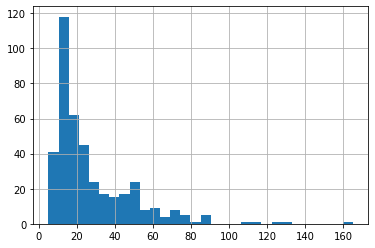

In [7]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)
max_seq_len = 40
print(max_seq_len)

In [8]:
# tokenize and encode sequences in the training set
if max_seq_len>512:
    max_seq_len = 512
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [9]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
print("train_y:",train_y)
# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
print("val_y:",val_y)

train_y: tensor([4, 4, 3, 5, 7, 5, 4, 1, 4, 6, 6, 4, 7, 4, 7, 4, 4, 2, 2, 4, 7, 4, 7, 3,
        4, 2, 7, 4, 4, 8, 7, 4, 4, 4, 7, 4, 4, 1, 2, 7, 6, 7, 4, 7, 1, 4, 4, 1,
        5, 5, 5, 4, 4, 8, 6, 7, 4, 7, 8, 4, 5, 4, 5, 2, 4, 4, 7, 7, 7, 4, 4, 3,
        7, 1, 5, 4, 4, 4, 4, 4, 7, 4, 2, 4, 4, 5, 7, 4, 2, 5, 3, 3, 2, 6, 4, 8,
        5, 7, 7, 7, 4, 7, 4, 7, 4, 7, 4, 2, 4, 4, 4, 4, 4, 4, 4, 7, 7, 4, 5, 3,
        4, 5, 5, 5, 1, 7, 7, 4, 4, 6, 7, 4, 5, 1, 4, 5, 3, 4, 7, 5, 2, 7, 1, 6,
        7, 7, 2, 4, 1, 4, 7, 4, 7, 3, 1, 7, 4, 5, 4, 4, 7, 4, 4, 7, 7, 8, 7, 4,
        4, 4, 5, 4, 2, 6, 7, 7, 4, 7, 4, 7, 5, 7, 7, 4, 7, 4, 4, 2, 7, 4, 4, 7,
        7, 4, 4, 4, 7, 1, 7, 4, 2, 4, 4, 4, 1, 1, 1, 7, 1, 4, 6, 4, 4, 7, 4, 8,
        4, 6, 4, 5, 6, 4, 8, 5, 7, 1, 4, 1, 3, 4, 4, 5, 4, 4, 1, 6, 7, 5, 4, 7,
        3, 5, 7, 3, 4, 7, 5, 6, 7, 4, 7, 4, 3, 7, 6, 4, 4, 4, 6, 6, 1, 4, 6, 1,
        4, 7, 4, 4, 4, 1, 4, 1, 4, 4, 5, 4, 4, 6, 3, 5, 5, 1, 7, 8, 7, 4, 8, 5,
        7, 8, 7, 4, 2, 4, 1, 3,

In [10]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [11]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [12]:
class BERT_Arch(nn.Module):
    def __init__(self, bert,label_map):
        super(BERT_Arch, self).__init__()
        self.bert = bert 
      
        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,len(label_map))

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

        #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)
        return x

In [13]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert,label_map)

# push the model to GPU
model = model.to(device)

In [14]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [15]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[1.54545455 2.68421053 2.31818182 0.33774834 1.02       2.31818182
 0.54255319 3.        ]


In [16]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 2

In [17]:
# function to train the model
def train():
    model.train()

    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
    total_labels =[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
        # progress update after every 50 batches.
        if step % 100 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()
        preds = np.argmax(preds, axis=1)
        # append the model predictions
        total_preds+=list(preds)
        total_labels+=labels.tolist()

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    #total_preds  = np.concatenate(total_preds, axis=0)
    f1 = f1_score(total_labels, total_preds, average='weighted')
    #returns the loss and predictions
    return avg_loss, f1

In [18]:
# function for evaluating the model
def evaluate():
  
    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []
    total_labels = []
    # iterate over batches
    for step,batch in enumerate(val_dataloader):
    
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

          # Calculate elapsed time in minutes.
          #elapsed = format_time(time.time() - t0)

          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()
            preds = np.argmax(preds, axis=1)
            total_preds+=list(preds)
            total_labels+=labels.tolist()
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    #total_preds  = np.concatenate(total_preds, axis=0)
    
    f1 = f1_score(total_labels, total_preds, average='weighted')
    return avg_loss, f1

In [19]:
def save_checkpoint(filename, epoch, model, optimizer, label_map, id2label):
    state = {
        'epoch': epoch,
        'model': model,
        'optimizer': optimizer,
        'label_map': label_map,
        'id_map':id2label}
    torch.save(state, filename)

In [20]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, f1_train = train()
    
    #evaluate model
    valid_loss, f1_valid = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        file_name = 'topic_saved_weights.pt'
        save_checkpoint(file_name, epoch, model, optimizer, label_map, id2label)
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'\nTraining F1: {f1_train:.3f}')
    print(f'Validation F1: {f1_valid:.3f}')


 Epoch 1 / 2


/opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/cuda/Loss.cu:271: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [14,0,0] Assertion `t >= 0 && t < n_classes` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.